In [1]:
import pandas as pd
import numpy as np
import quandl
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
from math import sqrt
import time
import itertools
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, RNN, GRU, SimpleRNN
from keras.models import load_model
import keras
import h5py
import requests
import os

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

quandl.ApiConfig.api_key = "zFtyXTJz6DTqqdvEy2gi"

Using TensorFlow backend.


In [ ]:
#Stock Data (DBA and WEAT not available from here)
#data = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'close'] }, ticker = ['DBA'], date = { 'gte': '2012-01-01', 'lte': '2018-04-13' })

### Futures: Continuous contracts (W# - contract # ahead)

In [5]:
#continuous futures W1 is front month
#W1 may18 prices start 3/15/18..futures trade until biz day before 15th of settle month
#data = quandl.get('CHRIS/CME_KW1')
#data.to_csv('CME_KW1.csv')

In [629]:
#data.head()

### Futures: Individual contracts (all data)

In [ ]:
#individual contract (July 2018)
#data = quandl.get('CME/WN2018')
#data = quandl.get('CME/WK2018')  #may2018'
#data = quandl.get('CME/WH2018')  #mar2018


In [ ]:
#data.iloc[635:,[3]]

### Combining the Financial data sets by Date

In [65]:
# dat = pd.read_csv("Data/CME_W4.csv")
# dat = dat.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpIntPvD'})
# print(dat.head())
# print(len(dat))
# dat.dtypes

# i = 1
# cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']
# dat = dat[cols]
# cols2 = ['W'+str(i) + "_" + x for x in cols[1:]]
# cols2.insert(0,'Date')
# dat.columns = cols2
# dat.head()

# Import, Merge, Clean Data

### Combine all the Futures Contract Data (5 futures files (W1-W5) and 4 stocks )

In [52]:
def fixDate(inDate):
    lst = inDate.split('/')
    if lst[2] < '20':
        lst[2] = '20'+lst[2]
    else:
        lst[2] = '19'+lst[2]
    return '/'.join(lst)
    
import glob

cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']

#get futures data files, sort by 13th char (digit)
filenamesFUT = glob.glob('./Data/CME_KW*.csv')
filenamesFUT = sorted(filenamesFUT, key=lambda x: x[12])

#for each file, subset/clean columns, join to W1 by date
for file in filenamesFUT:
    lst = file.split('W')
    cNum = int(lst[1][:1])
    df = pd.read_csv(file)
    
    #W1-3 have date without century, add full year
    #if cNum <= 3:
    #df['Date'] = df['Date'].apply(fixDate)
    df['Date'] = pd.to_datetime(df['Date'])
    
    df = df.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpInt'})
    df = df[cols]
    colsTxt = ['KW'+str(cNum) + "_" + x for x in cols[1:]]
    colsTxt.insert(0, 'Date')
    df.columns = colsTxt

    if cNum == 1:
        dat = df
    else:
        dat = dat.merge(df, how='left', on='Date')

### Add Equity data

In [53]:
filenames = glob.glob('./Data/*.csv')
filenamesEQ = [x for x in filenames if x not in filenamesFUT]

colsEQ = ['Date','Close']

for file in filenamesEQ:
    if 'financialALL' not in file and 'imputed' not in file:
        df = pd.read_csv(file, parse_dates=[0])
        df = df[colsEQ]
    
        #extract ticker
        ticker = file.split('/')[2].split('.')[0]

        df.columns = ['Date', ticker]
        
        #merge with futures data
        dat = dat.merge(df, how='left', on='Date')

In [54]:
dat.columns

Index(['Date', 'KW1_Open', 'KW1_High', 'KW1_Low', 'KW1_Last', 'KW1_Vol',
       'KW1_OpInt', 'KW3_Open', 'KW3_High', 'KW3_Low', 'KW3_Last', 'KW3_Vol',
       'KW3_OpInt', 'ADM', 'BG', 'WEAT', 'DBA'],
      dtype='object')

In [55]:
#keep only the W3 futures contract (3 months ahead rolling contract)
dat = dat[['Date', 'KW3_Open', 'KW3_High', 'KW3_Low', 'KW3_Last', 'KW3_Vol', 'KW3_OpInt', 'ADM',
     'BG', 'WEAT', 'DBA']]

#change col names
dat.columns = ['Date', 'FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Close', 'FUT_Vol', 'FUT_OpInt', 'ADM',
     'BG', 'WEAT', 'DBA']

dat.head()

,Date,FUT_Open,FUT_High,FUT_Low,FUT_Close,FUT_Vol,FUT_OpInt,ADM,BG,WEAT,DBA
0,1976-04-09,389.5,389.50,387.00,388.00,95,480,NaN,NaN,NaN,NaN
1,1976-04-12,384.0,385.00,383.00,383.50,115,580,NaN,NaN,NaN,NaN
2,1976-04-13,383.0,383.00,381.00,381.00,5,585,NaN,NaN,NaN,NaN
3,1976-04-14,384.0,384.25,381.75,381.75,55,635,NaN,NaN,NaN,NaN
4,1976-04-15,381.5,394.50,381.50,390.00,230,645,NaN,NaN,NaN,NaN


In [56]:
# make Date the index
dat = dat.set_index('Date')

#save to csv
dat.to_csv("./Data/financialALL.csv")

### Split data into 3 datasets (futures, stocks, weather)

In [57]:
futures = dat[['FUT_Open','FUT_High','FUT_Low','FUT_Close','FUT_Vol','FUT_OpInt']]
stocks = dat[['ADM','BG','WEAT','DBA']]
stocks.dropna(inplace=True)

In [58]:
weather = pd.read_csv("./Data/final_weather_imputed.csv", header=0)
weather['Date'] = pd.to_datetime(weather['day'])
weather.drop(columns=['day'], inplace=True)
weather.set_index('Date', inplace=True)
weather.head()

,1F0_avg_rh,1F0_avg_wind_drct,1F0_avg_wind_speed_kts,1F0_climo_high_f,1F0_climo_low_f,1F0_climo_precip_in,1F0_max_dewpoint_f,1F0_max_rh,1F0_max_temp_f,1F0_min_dewpoint_f,...,WWR_climo_precip_in,WWR_max_dewpoint_f,WWR_max_rh,WWR_max_temp_f,WWR_min_dewpoint_f,WWR_min_rh,WWR_min_temp_f,WWR_precip_in,WWR_snow_in,WWR_snowd_in
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,88.6985,4.95102,3.557650,54.7,32.5,0.06,37.0,100.0,43.0,37.0,...,0.03,34.0,100.0000,37.0,30.0,86.6944,30.0,0.08,1.361442,1.713048
2005-02-01,85.1454,30.55420,5.152340,54.9,32.6,0.07,39.0,100.0,43.0,37.0,...,0.03,34.0,100.0000,36.0,34.0,80.5077,34.0,0.00,1.068212,2.398019
2005-02-02,86.7985,355.15000,3.563940,55.0,32.8,0.08,37.0,100.0,43.0,34.0,...,0.02,34.0,100.0000,46.0,30.0,60.7869,30.0,0.00,0.247806,0.096416
2005-02-03,73.9092,351.57600,1.132680,55.2,33.0,0.06,36.0,100.0,55.0,28.0,...,0.03,37.0,92.9165,61.0,30.0,28.7724,30.0,0.00,-0.790440,-1.163829
2005-02-04,69.7364,211.26100,0.581704,55.4,33.2,0.07,37.0,100.0,59.0,28.0,...,0.03,34.0,93.0280,63.0,34.0,25.3208,34.0,0.00,-0.350570,-0.533856


# Feature Engineering

### OHLC Average

Many traders believe in technical analysis, forecasting prices by analyzing statistics based on trading activity. One particular metric watched is the OHLC average which is the average of the Open, High, Low, and Closing prices of a security. 

In [59]:
#add OHLC for each of the futures contracts row
futures['FUT_OHLC'] = np.sum(futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Close']],axis=1) / 4

### Moving Averages

In [60]:
MoveAvg = [50,100,200]
for ma in MoveAvg:
    #add MA columns by taking the mean over specificed window size
    futures['FUT_{}MA'.format(ma)] = futures['FUT_Close'].rolling(window=ma).mean()

### Percent Change

In [61]:
futures['FUT_%Chg'] = futures['FUT_Close'].pct_change()

### Closing price one month ahead (will be the label)

In [62]:
windowSize = 22  #number of days in a month to window data
lookAhead = 10
# futures['FUT_CloseAhead'] = futures['FUT_Close'].shift(-lookAhead)  #**** update col selection below as well
futures.dropna(inplace=True)

#moving FUT_Close to 2nd to last col
futures = futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt',
       'FUT_OHLC', 'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close']]

#uncomment and comment above if adding CloseAhead
# futures = futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt',
#        'FUT_OHLC', 'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close','FUT_CloseAhead']]

### Normalize the data  (call function for whichever cols we want to normalize)

3 datasets after this section are:
<ul>
<li>fut_norm
<li>weather_norm
<li>stk_norm
</ul>

In [64]:
def normalizeData(data):
    minMax = MinMaxScaler()
    normData = minMax.fit_transform(data.values.reshape(-1,1)).ravel()
    return normData

In [66]:
#normalize futures data (except the close)
fut_norm = futures.iloc[:,:-1].apply(normalizeData, axis=0)

#do close separately so can use model later to denorm
close_normalizer = MinMaxScaler()
fut_norm['FUT_Close'] = close_normalizer.fit_transform(futures.iloc[:,-1].values.reshape(-1,1)).ravel()

In [67]:
#normalize stock and weather data
stk_norm = stocks.iloc[:,:].apply(normalizeData, axis=0)
weather_norm = weather.iloc[:,:].apply(normalizeData, axis=0)

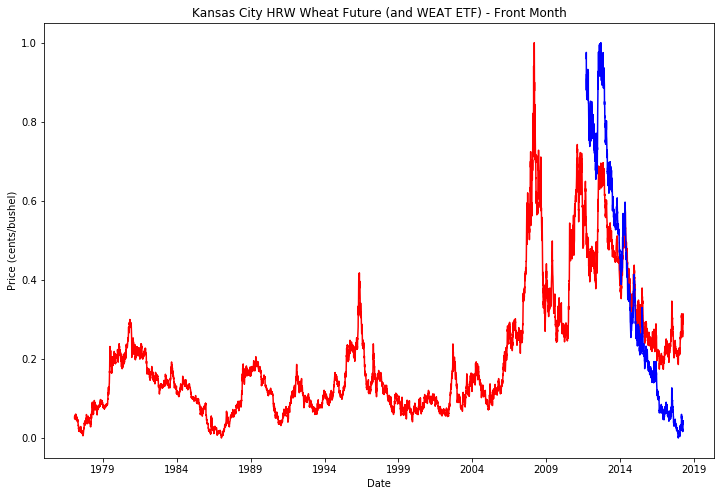

In [68]:
plt.figure(figsize=(12,8))
plt.plot(fut_norm['FUT_Close'], color='r', label='W1')
plt.plot(stk_norm['WEAT'], color='b')
plt.xlabel('Date')
plt.ylabel('Price (cents/bushel)')
plt.title('Kansas City HRW Wheat Future (and WEAT ETF) - Front Month');

### Prep Data for NN

3 datasets (pre-windowing)
<ul>
<li>fut_norm
<li>fut_weather_norm
<li>fut_weatherLen_norm (futures only but weathersLength)
<li>fut_stk_weather_norm
<li>fut_stkLen_weatherLen_norm (futures only but stockLength)
<li>fut_stkLen_weather_norm (futures & weather only but stockLength)
</ul>

In [115]:
fut_weather_norm = weather_norm.merge(fut_norm, left_index=True, right_index=True)
fut_weatherLen_norm = fut_weather_norm[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt', 'FUT_OHLC',
       'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close']]

In [119]:
len(fut_weather_norm)

3272

In [122]:
fut_stk_weather_norm = stk_norm.merge(fut_weather_norm, left_index=True, right_index=True)
fut_stkLen_weatherLen_norm = fut_stk_weather_norm[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt', 'FUT_OHLC',
       'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close']]
fut_stkLen_weather_norm = fut_stk_weather_norm.drop(columns=['ADM','BG','DBA','WEAT'])

In [71]:
#creates the windowed data
def prepDataValid(df, window=30):
    
    newData = []

    data = df.as_matrix()
    
    for i in range(len(data) - window): 
        newData.append(data[i: i + (window+1)]) # moving window of data, add one as index starts at 0
    
    
    newData = np.array(newData)
    split = int(round(len(newData)/3))

    XTrain = newData[:split, :-1]    # data for days d in a month
    yTrain = newData[:split,-1][:,-1] # data for day  d+1 only last col (FUT_CloseAhead)
    
    XValid = newData[split:(2*split),:-1]
    yValid = newData[split:(2*split),-1][:,-1]
    
    XTest = newData[(2*split):,:-1]
    yTest = newData[(2*split):,-1][:,-1]

    return [XTrain, yTrain, XValid, yValid, XTest, yTest]

In [197]:
#creates the windowed data
def prepData(df, window=30):
    
    newData = []

    data = df.as_matrix()
    
    for i in range(len(data) - window): 
        newData.append(data[i: i + (window+1)]) # moving window of data, add one as index starts at 0
    
    newData = np.array(newData)
    split = int(round(len(newData)/3))

    XTrain = newData[:(2*split), :-1]    # data for days d in a month
    yTrain = newData[:(2*split),-1][:,-1] # data for day  d+1 only last col (FUT_CloseAhead)
    
    #XValid = newData[split:(2*split),:-1]
    #yValid = newData[split:(2*split),-1][:,-1]
    
    XTest = newData[(2*split):,:-1]
    yTest = newData[(2*split):,-1][:,-1]

    return [XTrain, yTrain, XTest, yTest]

In [72]:
#sets up non-windowing data base NN (assumes last col is target)
def prepDataBase(df):
    split = int(round(len(df)/3))
    df = np.array(df)
    XTrain = df[:(2*split), :-1]    # first split of rows, all but last col
    yTrain = df[:(2*split),-1]      # only last col
    
    #XValid = df[split:(2*split),:-1]
    #yValid = df[split:(2*split),-1]
    
    XTest = df[(2*split):,:-1]
    yTest = df[(2*split):,-1]
    
    return [XTrain, yTrain, XTest, yTest]

In [ ]:
# #sets up non-windowing data base NN (assumes last col is target)
# def prepDataBase(df):
#     split = int(round(len(df)/3))
#     df = np.array(df)
#     XTrain = df[:split, :-1]    # first split of rows, all but last col
#     yTrain = df[:split,-1]      # only last col
    
#     XValid = df[split:(2*split),:-1]
#     yValid = df[split:(2*split),-1]
    
#     XTest = df[(2*split):,:-1]
#     yTest = df[(2*split):,-1]
    
#     return [XTrain, yTrain, XValid, yValid, XTest, yTest]

# Windowing of Data 

predData() returns RNN ready data: 
<ul>
<li>XTrain
<li>yTrain
<li>XValid
<li>yValid
<li>XTest
<li>yTest
</ul>

In [ ]:
#get data split to do validation
#just futures data (back to 1976)
XTrainF, yTrainF, XValidF, yValidF, XTestF, yTestF = prepDataValid(fut_norm, windowSize)
XTrainFW, yTrainFW, XValidFW, yValidFW, XTestFW, yTestFW = prepDataValid(fut_weather_norm, windowSize)
XTrainFSW, yTrainFSW, XValidFSW, yValidFSW, XTestFSW, yTestFSW = prepDataValid(fut_stk_weather_norm, windowSize)

In [73]:
# get the non-windowed data for baseline NN
XTrainF_Base, yTrainF_Base, XTestF_Base, yTestF_Base = prepDataBase(fut_norm)
XTrainFW_Base, yTrainFW_Base, XTestFW_Base, yTestFW_Base = prepDataBase(fut_weather_norm)
XTrainFSW_Base, yTrainFSW_Base, XTestFSW_Base, yTestFSW_Base = prepDataBase(fut_stk_weather_norm)


In [198]:
## >>>>> label is FUT_CloseAhead (close price 22 days forward)  ... should we just use FUT_Close?

#just futures data (back to 1976)
XTrainF, yTrainF, XTestF, yTestF = prepData(fut_norm, windowSize)

#futures and weather (back to 2005)
XTrainFW, yTrainFW, XTestFW, yTestFW = prepData(fut_weather_norm, windowSize)
XTrainFW_F, yTrainFW_F, XTestFW_F, yTestFW_F = prepData(fut_weatherLen_norm, windowSize)

#futures, weather, and stocks (back to 2011)
XTrainFSW, yTrainFSW, XTestFSW, yTestFSW = prepData(fut_stk_weather_norm, windowSize)
XTrainFSW_F, yTrainFSW_F, XTestFSW_F, yTestFSW_F = prepData(fut_stkLen_weatherLen_norm, windowSize)
XTrainFSW_FW, yTrainFSW_FW, XTestFSW_FW, yTestFSW_FW = prepData(fut_stkLen_weather_norm, windowSize)

### Check if shapes look ok

In [200]:
print(XTrainF.shape, yTrainF.shape, XTestF.shape, yTestF.shape)

(6910, 22, 11) (6910,) (3454, 22, 11) (3454,)


In [201]:
print(XTrainFW.shape, yTrainFW.shape, XTestFW.shape, yTestFW.shape)

(2166, 22, 1406) (2166,) (1084, 22, 1406) (1084,)


In [202]:
print(XTrainFSW.shape, yTrainFSW.shape, XTestFSW.shape, yTestFSW.shape)

(1054, 22, 1410) (1054,) (526, 22, 1410) (526,)


# Neural Network (RNN, GRU, LSTM)

In [241]:
#default layers = 6, neurons list always should equal 6
def build_NN(inShape, neuronList, rnnLayers=2, nnType='RNN'):
    
    model = Sequential()
    model.add(Dense(neuronList[0], input_shape=(inShape[0], inShape[1])))  #input layer
    
    #print(inShape[1], rnnLayers, neuronList)
    if nnType == 'RNN':
        for i in range(rnnLayers):
            if i != rnnLayers-1:
                model.add(SimpleRNN(neuronList[1], return_sequences=True))
            else:
                model.add(SimpleRNN(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'GRU':
        for i in range(rnnLayers):
            if i != rnnLayers-1:
                model.add(GRU(neuronList[1], return_sequences=True))
            else:
                model.add(GRU(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'LSTM':
        for i in range(rnnLayers):
            if i != rnnLayers-1:
                model.add(LSTM(neuronList[1], return_sequences=True)) 
            else:
                model.add(LSTM(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))      
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'BASE':
        for i in range(rnnLayers):
            if i != rnnLayers-1:
                model.add(Dense(neuronList[1], activation='relu'))
            else:
                model.add(Dense(neuronList[2], activation='relu'))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    else:
        print('should not be here')
    
    model.add(Dense(neuronList[5], activation='linear', kernel_initializer="uniform")) #output layer
      
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    #model.summary() 

    return model

### Build Models for each dataset and type of NN

In [ ]:
#get the input shapes for each dataset to use input layer of NN model
inShapeF = [windowSize, len(fut_norm.columns)]
inShapeFW = [windowSize, len(fut_weather_norm.columns)]
inShapeFSW = [windowSize, len(fut_stk_weather_norm.columns)]

### Validation

In [172]:
neuronsList = [[512, 256, 256, 64, 32, 1],[1024, 512, 512, 128, 64, 1], [256, 128, 128, 32, 16, 1]]
layersList = [2,4,6]
epochs = 8
batchSize = 1000

scoreTable = []
score = []

for layers in layersList:
    for neurons in neuronsList:
        modelLSTM_F = build_NN(inShapeF, neurons, rnnLayers=layers, nnType='LSTM')
        modelLSTM_FW = build_NN(inShapeFW, neurons, rnnLayers=layers, nnType='LSTM')
        modelLSTM_FSW = build_NN(inShapeFSW, neurons, rnnLayers=layers, nnType='LSTM')
        
        modelLSTM_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, verbose=1)
        modelLSTM_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, verbose=1)
        modelLSTM_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, verbose=1)
        
        temp = []
        temp.append(modelLSTM_F.evaluate(XValidF, yValidF, verbose=0)[0])
        temp.append(modelLSTM_FW.evaluate(XValidFW, yValidFW, verbose=0)[0])
        temp.append(modelLSTM_FSW.evaluate(XValidFSW, yValidFSW, verbose=0)[0])
        
        score.append(np.mean(temp))
    
    scoreTable.append(score)
    score = []
    

Epoch 1/8
3455/3455 [==============================] - 18s 5ms/step - loss: 0.0122 - acc: 2.8944e-04
Epoch 2/8
3455/3455 [==============================] - 9s 3ms/step - loss: 0.0029 - acc: 2.8944e-04
Epoch 3/8
3455/3455 [==============================] - 9s 3ms/step - loss: 0.0013 - acc: 2.8944e-04
Epoch 4/8
3455/3455 [==============================] - 9s 3ms/step - loss: 5.7869e-04 - acc: 2.8944e-04
Epoch 5/8
3455/3455 [==============================] - 9s 3ms/step - loss: 5.5882e-04 - acc: 2.8944e-04
Epoch 6/8
3455/3455 [==============================] - 9s 3ms/step - loss: 4.0230e-04 - acc: 2.8944e-04
Epoch 7/8
3455/3455 [==============================] - 9s 3ms/step - loss: 3.1311e-04 - acc: 2.8944e-04
Epoch 8/8
3455/3455 [==============================] - 10s 3ms/step - loss: 2.5554e-04 - acc: 2.8944e-04
Epoch 1/8
1083/1083 [==============================] - 15s 14ms/step - loss: 0.1553 - acc: 0.0000e+00
Epoch 2/8
1083/1083 [==============================] - 4s 4ms/step - loss: 0

1083/1083 [==============================] - 6s 6ms/step - loss: 0.0500 - acc: 0.0000e+00
Epoch 3/8
1083/1083 [==============================] - 7s 6ms/step - loss: 0.0474 - acc: 0.0000e+00
Epoch 4/8
1083/1083 [==============================] - 6s 6ms/step - loss: 0.0388 - acc: 0.0000e+00
Epoch 5/8
1083/1083 [==============================] - 6s 6ms/step - loss: 0.0388 - acc: 0.0000e+00
Epoch 6/8
1083/1083 [==============================] - 6s 6ms/step - loss: 0.0388 - acc: 0.0000e+00
Epoch 7/8
1083/1083 [==============================] - 6s 6ms/step - loss: 0.0387 - acc: 0.0000e+00
Epoch 8/8
1083/1083 [==============================] - 6s 6ms/step - loss: 0.0387 - acc: 0.0000e+00
Epoch 1/8
527/527 [==============================] - 14s 27ms/step - loss: 0.2820 - acc: 0.0000e+00
Epoch 2/8
527/527 [==============================] - 3s 6ms/step - loss: 0.2654 - acc: 0.0000e+00
Epoch 3/8
527/527 [==============================] - 3s 6ms/step - loss: 0.2216 - acc: 0.0000e+00
Epoch 4/8
527/

Epoch 4/8
527/527 [==============================] - 4s 8ms/step - loss: 0.0367 - acc: 0.0000e+00
Epoch 5/8
527/527 [==============================] - 4s 8ms/step - loss: 0.0144 - acc: 0.0000e+00
Epoch 6/8
527/527 [==============================] - 4s 8ms/step - loss: 0.0287 - acc: 0.0000e+00
Epoch 7/8
527/527 [==============================] - 4s 8ms/step - loss: 0.0136 - acc: 0.0000e+00
Epoch 8/8
527/527 [==============================] - 4s 8ms/step - loss: 0.0070 - acc: 0.0000e+00
Epoch 1/8
3455/3455 [==============================] - 99s 29ms/step - loss: 0.0427 - acc: 2.8944e-04
Epoch 2/8
3455/3455 [==============================] - 75s 22ms/step - loss: 0.0122 - acc: 2.8944e-04
Epoch 3/8
3455/3455 [==============================] - 78s 22ms/step - loss: 0.0097 - acc: 2.8944e-04
Epoch 4/8
3455/3455 [==============================] - 79s 23ms/step - loss: 0.0041 - acc: 2.8944e-04
Epoch 5/8
3455/3455 [==============================] - 82s 24ms/step - loss: 0.0015 - acc: 2.8944e-04


### Get the bestLayers and bestNeurons from 'Grid Search'

In [182]:
scoreTableNP = np.array(scoreTable)
idx = np.where(scoreTableNP == np.min(scoreTableNP))

bestLayers = np.array(layersList)[idx[0]][0]
bestNeurons = np.array(neuronsList)[idx[1]][0]

In [207]:
list(bestNeurons)

[256, 128, 128, 32, 16, 1]

In [239]:
#neurons list
#neurons = [512, 256, 256, 64, 32, 1]
neurons2 = list(bestNeurons)
neurons = [256, 256, 128, 32, 16, 1]
epochs = 10
batchSize = 300

In [240]:
#modelBASE_F = build_NN(inShapeF, neurons, nnType='BASE')
modelRNN_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='LSTM')

#Futures & Weather
modelRNN_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='LSTM')

#Futures only but Weather length
modelRNN_FW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='LSTM')


# Futures & Stock & Weather
modelRNN_FSW = build_NN(inShapeFSW, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FSW = build_NN(inShapeFSW, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FSW = build_NN(inShapeFSW, neurons, rnnLayers=bestLayers, nnType='LSTM')

#Futures only but stock length
modelRNN_FSW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FSW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FSW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='LSTM')

#Futures & weather only but stock length
modelRNN_FSW_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FSW_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FSW_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='LSTM')

print(modelRNN_F.summary(),'\n')
print(modelGRU_F.summary(),'\n')
print(modelLSTM_F.summary(),'\n')

11 4 [256, 256, 128, 32, 16, 1]
11 4 [256, 256, 128, 32, 16, 1]
11 4 [256, 256, 128, 32, 16, 1]
1406 4 [256, 256, 128, 32, 16, 1]
1406 4 [256, 256, 128, 32, 16, 1]
1406 4 [256, 256, 128, 32, 16, 1]
11 4 [256, 256, 128, 32, 16, 1]
11 4 [256, 256, 128, 32, 16, 1]
11 4 [256, 256, 128, 32, 16, 1]
1410 4 [256, 256, 128, 32, 16, 1]
1410 4 [256, 256, 128, 32, 16, 1]
1410 4 [256, 256, 128, 32, 16, 1]
11 4 [256, 256, 128, 32, 16, 1]
11 4 [256, 256, 128, 32, 16, 1]
11 4 [256, 256, 128, 32, 16, 1]
1406 4 [256, 256, 128, 32, 16, 1]
1406 4 [256, 256, 128, 32, 16, 1]
1406 4 [256, 256, 128, 32, 16, 1]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_470 (Dense)            (None, 22, 256)           3072      
_________________________________________________________________
simple_rnn_66 (SimpleRNN)    (None, 22, 256)           131328    
_________________________________________________________________
simple_rnn

In [242]:
#get the loss
def model_traintest_loss(mod, XTrain, yTrain, XTest, yTest):
    trainLoss = mod.evaluate(XTrain, yTrain, verbose=0)
    testLoss = mod.evaluate(XTest, yTest, verbose=0)
    print('Train Score: {:.5f} MSE ({:.2f} RMSE)'.format(trainLoss[0], math.sqrt(trainLoss[0])))
    print('Test Score: {:.5f} MSE ({:.2f} RMSE)'.format(testLoss[0], math.sqrt(testLoss[0])))
    return trainLoss[0], testLoss[0]

def model_loss(mod, X, y):
    loss = mod.evaluate(X, y, verbose=0)
    #print('Train Score: {:.5f} MSE ({:.2f} RMSE)'.format(trainLoss[0], math.sqrt(trainLoss[0])))
    #print('Test Score: {:.5f} MSE ({:.2f} RMSE)'.format(testLoss[0], math.sqrt(testLoss[0])))
    return loss[0]  #returns MSE

In [243]:
# for model in modelsNN:
#     fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
#     fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
#     fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

## Fit Models:  Futures

In [ ]:
%%time
modelRNN_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 5528 samples, validate on 1382 samples
Epoch 1/10
5528/5528 [==============================] - 28s 5ms/step - loss: 0.0098 - acc: 1.8090e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 2/10
5528/5528 [==============================] - 8s 1ms/step - loss: 0.0042 - acc: 1.8090e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 3/10
5528/5528 [==============================] - 8s 1ms/step - loss: 0.0030 - acc: 1.8090e-04 - val_loss: 2.9240e-04 - val_acc: 0.0000e+00
Epoch 4/10
5528/5528 [==============================] - 8s 1ms/step - loss: 7.7829e-04 - acc: 1.8090e-04 - val_loss: 2.5875e-04 - val_acc: 0.0000e+00
Epoch 5/10
5528/5528 [==============================] - 8s 1ms/step - loss: 3.1380e-04 - acc: 1.8090e-04 - val_loss: 1.8219e-04 - val_acc: 0.0000e+00
Epoch 6/10
5528/5528 [==============================] - 8s 1ms/step - loss: 1.9951e-04 - acc: 1.8090e-04 - val_loss: 1.3386e-04 - val_acc: 0.0000e+00
Epoch 7/10
5528/5528 [==============================] - 8s 1ms/step - l

## Fit Models:  Futures + Weather data

In [130]:
%%time
modelRNN_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 866 samples, validate on 217 samples
Epoch 1/50
866/866 [==============================] - 5s 5ms/step - loss: 0.2240 - acc: 0.0000e+00 - val_loss: 0.0857 - val_acc: 0.0000e+00
Epoch 2/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0889 - acc: 0.0000e+00 - val_loss: 0.0254 - val_acc: 0.0000e+00
Epoch 3/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0491 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 4/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0470 - acc: 0.0000e+00 - val_loss: 0.0110 - val_acc: 0.0000e+00
Epoch 5/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0454 - acc: 0.0000e+00 - val_loss: 0.0176 - val_acc: 0.0000e+00
Epoch 6/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0455 - acc: 0.0000e+00 - val_loss: 0.0157 - val_acc: 0.0000e+00
Epoch 7/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0449 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 9/50
866/866 [==============================] - 3s 3ms/step - loss: 0.0450 - acc: 0.0000e+00 - val_loss: 0.0173 - val_acc: 0.0000e+00
Epoch 10/50
866/866 [==============================] - 3s 3ms/step - loss: 0.0454 - acc: 0.0000e+00 - val_loss: 0.0142 - val_acc: 0.0000e+00
Epoch 11/50
866/866 [==============================] - 3s 3ms/step - loss: 0.0448 - acc: 0.0000e+00 - val_loss: 0.0119 - val_acc: 0.0000e+00
Epoch 12/50
866/866 [==============================] - 3s 3ms/step - loss: 0.0451 - acc: 0.0000e+00 - val_loss: 0.0119 - val_acc: 0.0000e+00
Epoch 13/50
866/866 [==============================] - 3s 3ms/step - loss: 0.0450 - acc: 0.0000e+00 - val_loss: 0.0140 - val_acc: 0.0000e+00
Epoch 14/50
866/866 [==============================] - 3s 3ms/step - loss: 0.0446 - acc: 0.0000e+00 - val_loss: 0.0161 - val_acc: 0.0000e+00
Epoch 15/50
866/866 [==============================] - 3s 3ms/step - loss: 0.0446 - acc: 0.0000e+00 - val_loss: 0.0151 - val_acc: 0.0000e+00
Epoch 16/50
86

Epoch 17/50
866/866 [==============================] - 3s 4ms/step - loss: 0.0452 - acc: 0.0000e+00 - val_loss: 0.0153 - val_acc: 0.0000e+00
Epoch 18/50
866/866 [==============================] - 3s 4ms/step - loss: 0.0453 - acc: 0.0000e+00 - val_loss: 0.0167 - val_acc: 0.0000e+00
Epoch 19/50
866/866 [==============================] - 3s 4ms/step - loss: 0.0456 - acc: 0.0000e+00 - val_loss: 0.0169 - val_acc: 0.0000e+00
Epoch 20/50
866/866 [==============================] - 3s 4ms/step - loss: 0.0456 - acc: 0.0000e+00 - val_loss: 0.0160 - val_acc: 0.0000e+00
Epoch 21/50
866/866 [==============================] - 3s 4ms/step - loss: 0.0454 - acc: 0.0000e+00 - val_loss: 0.0146 - val_acc: 0.0000e+00
Epoch 22/50
866/866 [==============================] - 3s 4ms/step - loss: 0.0452 - acc: 0.0000e+00 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 23/50
866/866 [==============================] - 3s 4ms/step - loss: 0.0451 - acc: 0.0000e+00 - val_loss: 0.0122 - val_acc: 0.0000e+00
Epoch 24/50
8

### Futures only (weather length)

In [131]:
%%time
modelRNN_FW_F.fit(XTrainFW_F, yTrainFW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FW_F.fit(XTrainFW_F, yTrainFW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FW_F.fit(XTrainFW_F, yTrainFW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 866 samples, validate on 217 samples
Epoch 1/50
866/866 [==============================] - 3s 4ms/step - loss: 0.1589 - acc: 0.0000e+00 - val_loss: 0.0922 - val_acc: 0.0000e+00
Epoch 2/50
866/866 [==============================] - 1s 1ms/step - loss: 0.0947 - acc: 0.0000e+00 - val_loss: 0.0089 - val_acc: 0.0000e+00
Epoch 3/50
866/866 [==============================] - 1s 1ms/step - loss: 0.0505 - acc: 0.0000e+00 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 4/50
866/866 [==============================] - 1s 1ms/step - loss: 0.0333 - acc: 0.0000e+00 - val_loss: 0.0420 - val_acc: 0.0000e+00
Epoch 5/50
866/866 [==============================] - 1s 1ms/step - loss: 0.0516 - acc: 0.0000e+00 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 6/50
866/866 [==============================] - 1s 999us/step - loss: 0.0166 - acc: 0.0012 - val_loss: 0.0274 - val_acc: 0.0000e+00
Epoch 7/50
866/866 [==============================] - 1s 977us/step - loss: 0.0281 - acc: 0.0012 - val_loss: 0.0038 

Epoch 10/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0166 - acc: 0.0000e+00 - val_loss: 0.0097 - val_acc: 0.0000e+00
Epoch 11/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0193 - acc: 0.0000e+00 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 12/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0160 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 13/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0096 - acc: 0.0012 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 14/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0012 - val_loss: 0.0127 - val_acc: 0.0000e+00
Epoch 15/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0012 - val_loss: 0.0258 - val_acc: 0.0000e+00
Epoch 16/50
866/866 [==============================] - 2s 2ms/step - loss: 0.0060 - acc: 0.0012 - val_loss: 0.0333 - val_acc: 0.0000e+00
Epoch 17/50
866/866 [========

Epoch 20/50
866/866 [==============================] - 2s 3ms/step - loss: 0.0031 - acc: 0.0012 - val_loss: 0.0310 - val_acc: 0.0000e+00
Epoch 21/50
866/866 [==============================] - 2s 3ms/step - loss: 0.0042 - acc: 0.0012 - val_loss: 0.0287 - val_acc: 0.0000e+00
Epoch 22/50
866/866 [==============================] - 2s 3ms/step - loss: 0.0039 - acc: 0.0012 - val_loss: 0.0207 - val_acc: 0.0000e+00
Epoch 23/50
866/866 [==============================] - 2s 3ms/step - loss: 0.0028 - acc: 0.0012 - val_loss: 0.0127 - val_acc: 0.0000e+00
Epoch 24/50
866/866 [==============================] - 2s 3ms/step - loss: 0.0022 - acc: 0.0012 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 25/50
866/866 [==============================] - 2s 3ms/step - loss: 0.0026 - acc: 0.0012 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 26/50
866/866 [==============================] - 2s 3ms/step - loss: 0.0031 - acc: 0.0012 - val_loss: 0.0050 - val_acc: 0.0000e+00
Epoch 27/50
866/866 [====================

## Fit Models: Futures + Weather + Stock data

In [140]:
%%time
modelRNN_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 421 samples, validate on 106 samples
Epoch 1/50
421/421 [==============================] - 4s 8ms/step - loss: 0.2024 - acc: 0.0000e+00 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 2/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0414 - acc: 0.0000e+00 - val_loss: 0.0671 - val_acc: 0.0000e+00
Epoch 3/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0523 - acc: 0.0000e+00 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 4/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0084 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 5/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0160 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 6/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0088 - acc: 0.0000e+00 - val_loss: 0.0110 - val_acc: 0.0000e+00
Epoch 7/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0101 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 9/50
421/421 [==============================] - 1s 4ms/step - loss: 0.0087 - acc: 0.0000e+00 - val_loss: 0.0043 - val_acc: 0.0000e+00
Epoch 10/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0074 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 11/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0088 - acc: 0.0000e+00 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 12/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0104 - val_acc: 0.0000e+00
Epoch 13/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0080 - acc: 0.0000e+00 - val_loss: 0.0097 - val_acc: 0.0000e+00
Epoch 14/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0076 - acc: 0.0000e+00 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 15/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 16/50
42

Epoch 17/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0082 - acc: 0.0000e+00 - val_loss: 0.0050 - val_acc: 0.0000e+00
Epoch 18/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0080 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0000e+00
Epoch 19/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0089 - acc: 0.0000e+00 - val_loss: 0.0111 - val_acc: 0.0000e+00
Epoch 20/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0099 - acc: 0.0000e+00 - val_loss: 0.0116 - val_acc: 0.0000e+00
Epoch 21/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0101 - acc: 0.0000e+00 - val_loss: 0.0100 - val_acc: 0.0000e+00
Epoch 22/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0095 - acc: 0.0000e+00 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 23/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0085 - acc: 0.0000e+00 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 24/50
4

### Futures only (stock length)

In [141]:
%%time
modelRNN_FSW_F.fit(XTrainFSW_F, yTrainFSW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FSW_F.fit(XTrainFSW_F, yTrainFSW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FSW_F.fit(XTrainFSW_F, yTrainFSW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 421 samples, validate on 106 samples
Epoch 1/50
421/421 [==============================] - 3s 8ms/step - loss: 0.2723 - acc: 0.0000e+00 - val_loss: 0.0963 - val_acc: 0.0000e+00
Epoch 2/50
421/421 [==============================] - 0s 1ms/step - loss: 0.1409 - acc: 0.0000e+00 - val_loss: 9.4204e-04 - val_acc: 0.0000e+00
Epoch 3/50
421/421 [==============================] - 0s 1ms/step - loss: 0.0090 - acc: 0.0000e+00 - val_loss: 0.0326 - val_acc: 0.0000e+00
Epoch 4/50
421/421 [==============================] - 0s 1ms/step - loss: 0.0228 - acc: 0.0000e+00 - val_loss: 4.8456e-04 - val_acc: 0.0000e+00
Epoch 5/50
421/421 [==============================] - 0s 1ms/step - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 6/50
421/421 [==============================] - 0s 1ms/step - loss: 0.0069 - acc: 0.0000e+00 - val_loss: 0.0080 - val_acc: 0.0000e+00
Epoch 7/50
421/421 [==============================] - 0s 1ms/step - loss: 0.0073 - acc: 0.0000e+00 - val_l

Epoch 8/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0200 - acc: 0.0000e+00 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 9/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0050 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 10/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 11/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0210 - acc: 0.0000e+00 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epoch 12/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0219 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 13/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0159 - acc: 0.0000e+00 - val_loss: 5.3086e-04 - val_acc: 0.0000e+00
Epoch 14/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0084 - acc: 0.0000e+00 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 15/50

Epoch 16/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0153 - acc: 0.0000e+00 - val_loss: 8.9910e-04 - val_acc: 0.0000e+00
Epoch 17/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0146 - acc: 0.0000e+00 - val_loss: 4.0791e-04 - val_acc: 0.0000e+00
Epoch 18/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0124 - acc: 0.0000e+00 - val_loss: 4.9007e-04 - val_acc: 0.0000e+00
Epoch 19/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0098 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 20/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 21/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0078 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0000e+00
Epoch 22/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0087 - acc: 0.0000e+00 - val_loss: 0.0115 - val_acc: 0.0000e+00
E

### Futures & Weather only (stock length)

In [142]:
%%time
modelRNN_FSW_FW.fit(XTrainFSW_FW, yTrainFSW_FW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FSW_FW.fit(XTrainFSW_FW, yTrainFSW_FW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FSW_FW.fit(XTrainFSW_FW, yTrainFSW_FW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 421 samples, validate on 106 samples
Epoch 1/50
421/421 [==============================] - 4s 10ms/step - loss: 0.3169 - acc: 0.0000e+00 - val_loss: 0.0862 - val_acc: 0.0000e+00
Epoch 2/50
421/421 [==============================] - 1s 2ms/step - loss: 0.1337 - acc: 0.0000e+00 - val_loss: 4.7825e-04 - val_acc: 0.0000e+00
Epoch 3/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0137 - acc: 0.0000e+00 - val_loss: 0.0214 - val_acc: 0.0000e+00
Epoch 4/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0148 - acc: 0.0000e+00 - val_loss: 0.0268 - val_acc: 0.0000e+00
Epoch 5/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0173 - acc: 0.0000e+00 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 6/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0085 - acc: 0.0000e+00 - val_loss: 5.6545e-04 - val_acc: 0.0000e+00
Epoch 7/50
421/421 [==============================] - 1s 2ms/step - loss: 0.0098 - acc: 0.0000e+00 - val_

Epoch 9/50
421/421 [==============================] - 1s 4ms/step - loss: 0.0078 - acc: 0.0000e+00 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 10/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0077 - acc: 0.0000e+00 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 11/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0077 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 12/50
421/421 [==============================] - 1s 4ms/step - loss: 0.0075 - acc: 0.0000e+00 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 13/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0075 - acc: 0.0000e+00 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 14/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0073 - acc: 0.0000e+00 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 15/50
421/421 [==============================] - 1s 3ms/step - loss: 0.0073 - acc: 0.0000e+00 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 16/50
42

Epoch 17/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0088 - acc: 0.0000e+00 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 18/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0080 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 19/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0080 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 20/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0085 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 21/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0089 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 22/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0089 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 23/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0085 - acc: 0.0000e+00 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 24/50
4

# Train & Test loss calculations

Produces 6 tables to compare
<ul>
<li>train_table_F 
<li>train_table_FW
<li>train_table_FSW
<li>test_table_F 
<li>test_table_FW
<li>test_table_FSW
</ul>


In [145]:
%%time
NNmods = ['RNN','GRU','LSTM']
DatasetsFSW = ['FUT','FUT_Weather','FUT_STK_Weather']
DatasetsFW = ['FUT','FUT_Weather']

loss_train_F = []
loss_train_FW = []
loss_train_FSW = []
loss_test_F = []
loss_test_FW = []
loss_test_FSW = []

#Futures only 
loss_train_F.append(model_loss(modelRNN_F, XTrainF, yTrainF))
loss_train_F.append(model_loss(modelGRU_F, XTrainF, yTrainF))
loss_train_F.append(model_loss(modelLSTM_F, XTrainF, yTrainF))

train_table_F = pd.DataFrame(loss_train_F, index=NNmods, columns=['FUT'])


#Futures & Weather
temp = []
temp.append(model_loss(modelRNN_FW_F, XTrainFW_F, yTrainFW_F))
temp.append(model_loss(modelRNN_FW, XTrainFW, yTrainFW))

loss_train_FW.append(temp)
temp = []

temp.append(model_loss(modelGRU_FW_F, XTrainFW_F, yTrainFW_F))
temp.append(model_loss(modelGRU_FW, XTrainFW, yTrainFW))

loss_train_FW.append(temp)
temp = []

temp.append(model_loss(modelLSTM_FW_F, XTrainFW_F, yTrainFW_F))
temp.append(model_loss(modelLSTM_FW, XTrainFW, yTrainFW))

loss_train_FW.append(temp)
temp = []

train_table_FW = pd.DataFrame(loss_train_FW, index=NNmods, columns=DatasetsFW)


#Futures & Stock & Weather
temp.append(model_loss(modelRNN_FSW_F, XTrainFSW_F, yTrainFSW_F))
temp.append(model_loss(modelRNN_FSW_FW, XTrainFSW_FW, yTrainFSW_FW))
temp.append(model_loss(modelRNN_FSW, XTrainFSW, yTrainFSW))

loss_train_FSW.append(temp)
temp = []

temp.append(model_loss(modelGRU_FSW_F, XTrainFSW_F, yTrainFSW_F))
temp.append(model_loss(modelGRU_FSW_FW, XTrainFSW_FW, yTrainFSW_FW))
temp.append(model_loss(modelGRU_FSW, XTrainFSW, yTrainFSW))

loss_train_FSW.append(temp)
temp = []

temp.append(model_loss(modelLSTM_FSW_F, XTrainFSW_F, yTrainFSW_F))
temp.append(model_loss(modelLSTM_FSW_FW, XTrainFSW_FW, yTrainFSW_FW))
temp.append(model_loss(modelLSTM_FSW, XTrainFSW, yTrainFSW))

loss_train_FSW.append(temp)
temp = []

train_table_FSW = pd.DataFrame(loss_train_FSW, index=NNmods, columns=DatasetsFSW)

#---------------------------------------------------------
#---------------Test--------------------------------------
#---------------------------------------------------------

#Futures only 
loss_test_F.append(model_loss(modelRNN_F,  XTestF, yTestF))
loss_test_F.append(model_loss(modelGRU_F,  XTestF, yTestF))
loss_test_F.append(model_loss(modelLSTM_F, XTestF, yTestF))

test_table_F = pd.DataFrame(loss_test_F, index=NNmods, columns=['FUT'])


#Futures & Weather
temp = []
temp.append(model_loss(modelRNN_FW_F, XTestFW_F, yTestFW_F))
temp.append(model_loss(modelRNN_FW,   XTestFW,   yTestFW))

loss_test_FW.append(temp)
temp = []

temp.append(model_loss(modelGRU_FW_F, XTestFW_F, yTestFW_F))
temp.append(model_loss(modelGRU_FW,   XTestFW,   yTestFW))

loss_test_FW.append(temp)
temp = []

temp.append(model_loss(modelLSTM_FW_F, XTestFW_F, yTestFW_F))
temp.append(model_loss(modelLSTM_FW,   XTestFW,   yTestFW))

loss_test_FW.append(temp)
temp = []

test_table_FW = pd.DataFrame(loss_test_FW, index=NNmods, columns=DatasetsFW)


#Futures & Stock & Weather
temp.append(model_loss(modelRNN_FSW_F,  XTestFSW_F,  yTestFSW_F))
temp.append(model_loss(modelRNN_FSW_FW, XTestFSW_FW, yTestFSW_FW))
temp.append(model_loss(modelRNN_FSW,    XTestFSW,    yTestFSW))

loss_test_FSW.append(temp)
temp = []

temp.append(model_loss(modelGRU_FSW_F, XTestFSW_F, yTestFSW_F))
temp.append(model_loss(modelGRU_FSW_FW, XTestFSW_FW, yTestFSW_FW))
temp.append(model_loss(modelGRU_FSW, XTestFSW, yTestFSW))

loss_test_FSW.append(temp)
temp = []

temp.append(model_loss(modelLSTM_FSW_F, XTestFSW_F, yTestFSW_F))
temp.append(model_loss(modelLSTM_FSW_FW, XTestFSW_FW, yTestFSW_FW))
temp.append(model_loss(modelLSTM_FSW, XTestFSW, yTestFSW))

loss_test_FSW.append(temp)
temp = []

test_table_FSW = pd.DataFrame(loss_test_FSW, index=NNmods, columns=DatasetsFSW)

CPU times: user 3min 38s, sys: 23.8 s, total: 4min 2s
Wall time: 45.8 s


In [146]:
train_table_F

,FUT
RNN,0.016516
GRU,0.019168
LSTM,0.019422


In [147]:
train_table_FW

,FUT,FUT_Weather
RNN,0.001756,0.031144
GRU,0.002193,0.031611
LSTM,0.002057,0.038657


In [148]:
train_table_FSW

,FUT,FUT_Weather,FUT_STK_Weather
RNN,0.000700,0.007005,0.006462
GRU,0.001896,0.010116,0.005893
LSTM,0.006664,0.007281,0.007129


In [149]:
test_table_F

,FUT
RNN,0.162192
GRU,0.162140
LSTM,0.162176


In [150]:
test_table_FW

,FUT,FUT_Weather
RNN,0.001475,0.009691
GRU,0.002154,0.009217
LSTM,0.001615,0.010008


In [151]:
test_table_FSW

,FUT,FUT_Weather,FUT_STK_Weather
RNN,0.005039,0.096848,0.093860
GRU,0.002960,0.123489,0.086791
LSTM,0.083259,0.096956,0.093466


# Denormalize the close data & predictions (using same normalizing model from much earlier)

In [152]:
def denormalize(norm_close):       
    #normalized_value = normalized_value.reshape(-1,1)

    #return df.shape, p.shape
    denorm_close = close_normalizer.inverse_transform(norm_close)
      
    return denorm_close

# Predictions: LSTM for FUT only

In [156]:
denormalize(yPred_norm)

array([[ 228.73051453],
       [ 228.76409912],
       [ 228.81941223],
       ..., 
       [ 227.50605774],
       [ 227.46653748],
       [ 227.35243225]], dtype=float32)

In [159]:
denormalize(yTestF.reshape(-1,1))

array([[ 377.5 ],
       [ 373.5 ],
       [ 370.75],
       ..., 
       [ 553.  ],
       [ 545.25],
       [ 533.75]])

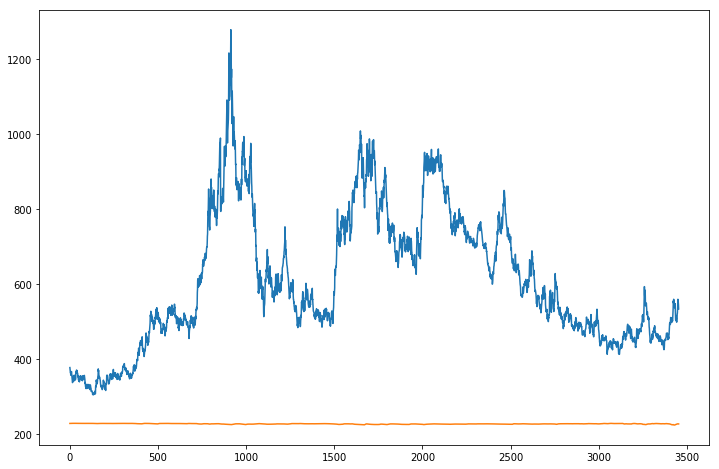

In [154]:
yPred_norm = modelLSTM_F.predict(XTestF)
yPred_denorm = denormalize(yPred_norm)
yTestF_denorm = denormalize(yTestF.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.plot(list(range(len(yTestF))), yTestF_denorm)
plt.plot(list(range(len(yTestF))), yPred_denorm);

In [161]:
XTestFW_F.shape

(1084, 22, 11)

In [162]:
yTestFW_F.shape

(1084,)

In [163]:
yPred_norm.shape

(1084, 1)

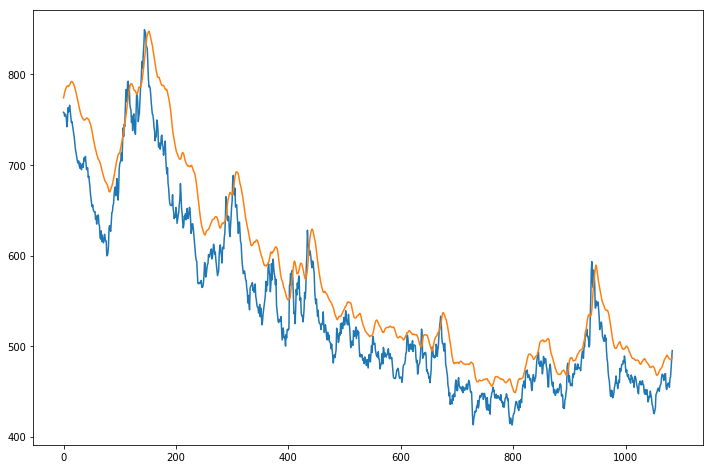

In [167]:
yPred_norm = modelLSTM_FW_F.predict(XTestFW_F)
yPred_denorm = denormalize(yPred_norm)
yTestFW_F_denorm = denormalize(yTestFW_F.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.plot(list(range(len(yTestFW_F))), yTestFW_F_denorm, label='actual')
plt.plot(list(range(len(yTestFW_F))), yPred_denorm, label='prediction');

### Predictions: LSTM for FUT+Weather

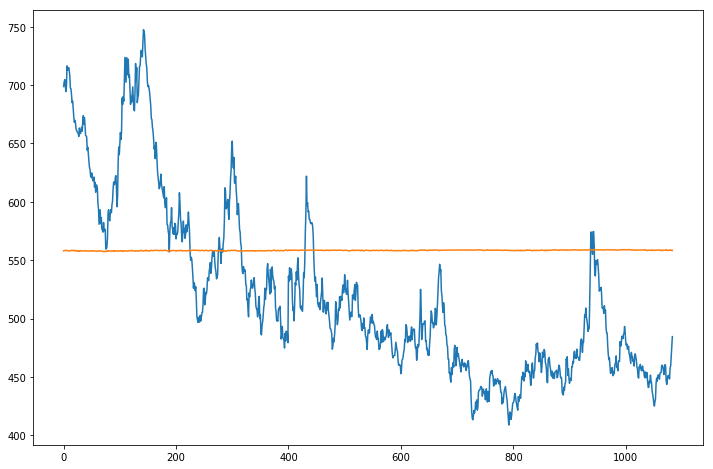

In [755]:
yPredFW_norm = modelLSTM_FW.predict(XTestFW)
yPredFW_denorm = denormalize(yPredFW_denorm)
yTestFW_denorm = denormalize(yTestFW.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.plot(list(range(len(yTestFW))), yTestFW_denorm)
plt.plot(list(range(len(yTestFW))), yPredFW_denorm);

In [752]:
yPredFW_norm

array([[ 558.01147461],
       [ 558.17163086],
       [ 558.21929932],
       ..., 
       [ 558.26690674],
       [ 558.69512939],
       [ 558.44006348]], dtype=float32)

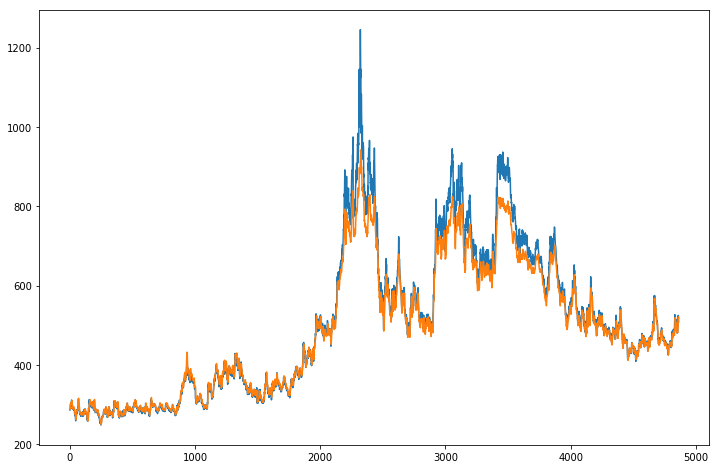